In [42]:
import cv2
import numpy as np
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt

In [48]:

# Initialize default parameter values

alpha = 0.008
beta = 40
gamma = 0.001
iterations = 10000
b = 10
n = 2
t = 10
a = 0.1
k = np.arange(230, 250, 1)
kernel = np.ones((5, 5), dtype=np.uint8)
structuring_element = np.array([[1, 1, 1],
                                [1,  0,  1],
                                [1, 1, 1]], dtype=np.uint8)

mov_file_path = 'vidd.mp4'
print(k)

[200 210 220 230 240]


In [49]:
def apply_snakes_model(image):
    global alpha, beta, gamma, iterations

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray_image.shape

    t = np.arange(0, 2*np.pi, 0.02)
    x = width*4/8+ 70*np.cos(t)
    y = height*2/10+ 70*np.sin(t)

    init = np.array([y, x]).T

    snake = active_contour(gaussian(gray_image, 1, preserve_range=False),
                    init, alpha=alpha, beta=beta, gamma=gamma, max_num_iter=iterations)
    return snake
def create_empty_frame(height, width):
    blank_image = np.zeros((height, width), dtype=np.uint8)
    return blank_image


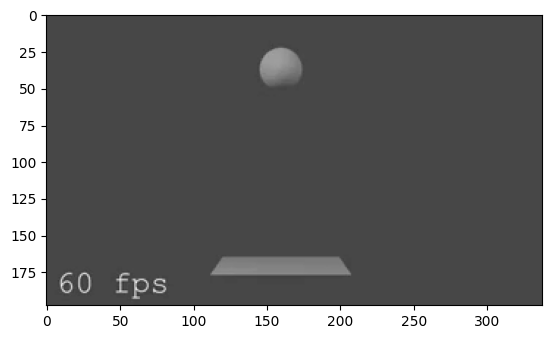

In [50]:
try:
    video = cv2.VideoCapture(mov_file_path)
except Exception as e:
    print(f'Error reading file: {e}')
        
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#frame_index = total_frames-116
frame_index = 1
video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

ret, prev_frame1 = video.read()
plt.imshow(prev_frame1)



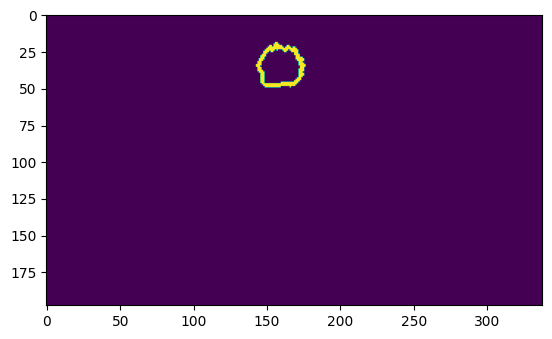

In [51]:

contour = apply_snakes_model(prev_frame1)
prev_frame = cv2.cvtColor(prev_frame1, cv2.COLOR_BGR2GRAY)
img_with_contour = prev_frame.copy()
contour = np.array(contour, dtype=np.int32)[:, ::-1]
contour = contour.reshape(-1, 1, 2)
C = create_empty_frame(prev_frame.shape[0], prev_frame.shape[1])

cv2.drawContours(C, contour, -1, (255, 255, 255), 2)
cv2.drawContours(img_with_contour, contour, -1, (255, 255, 255), 2)
plt.imshow(C)

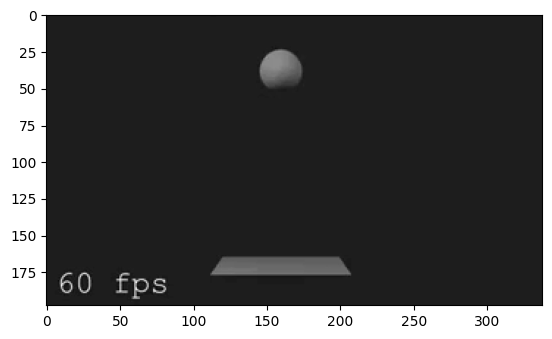

In [52]:
frame_index2 = frame_index+1
video.set(cv2.CAP_PROP_POS_FRAMES, frame_index2)
ret, frame = video.read()

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame, cmap='gray')

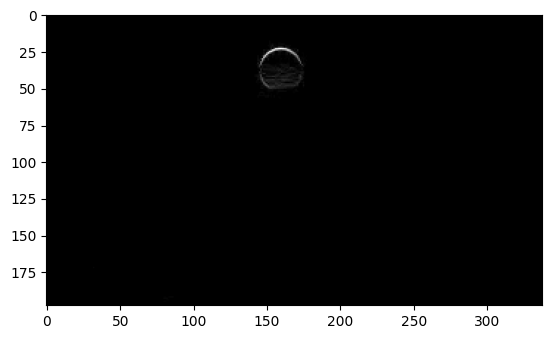

In [53]:
# Perform frame subtraction
O = cv2.absdiff(frame, prev_frame)
plt.imshow(O, cmap='gray')

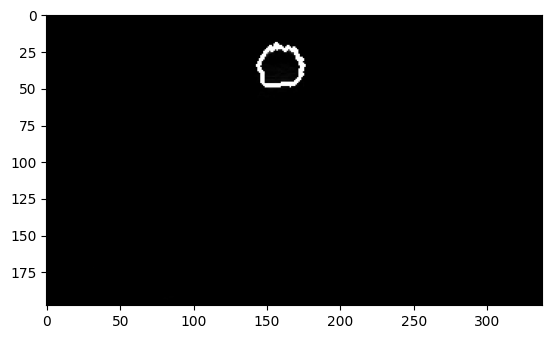

In [54]:
overlapping_image = cv2.max(O , C)
plt.imshow(overlapping_image, cmap='gray')

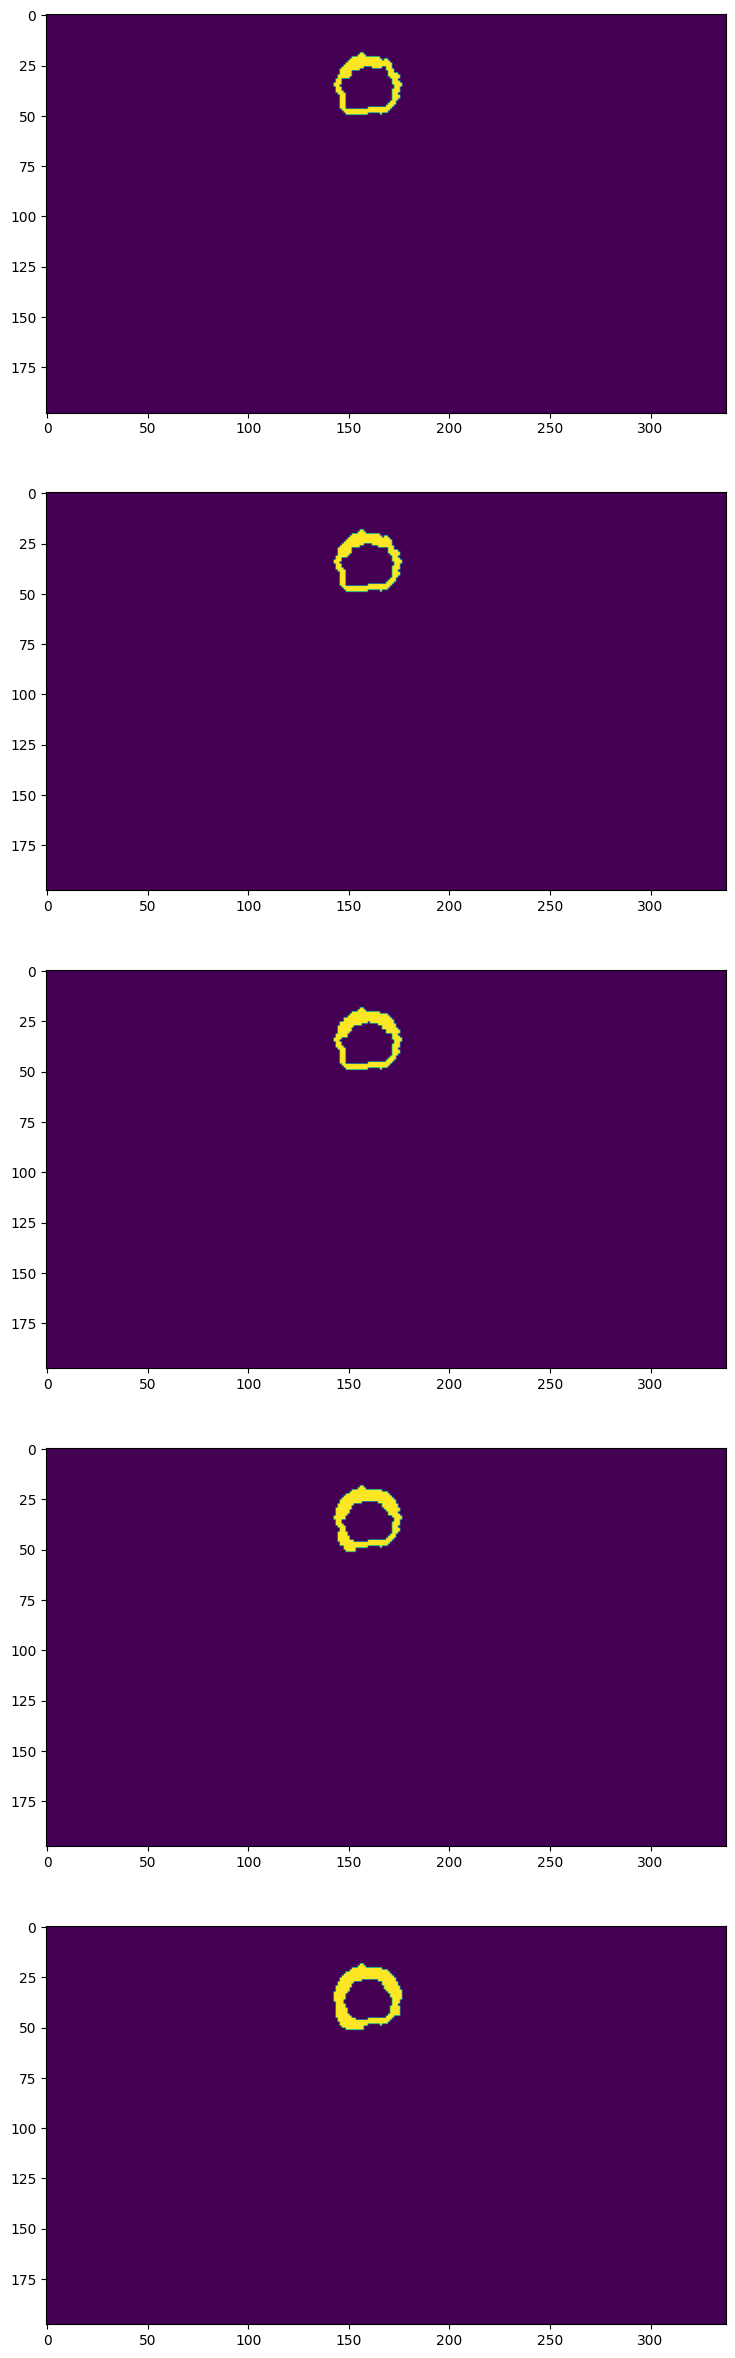

In [55]:
fig, ax = plt.subplots(len(k), figsize=(30,30))
i=0
overlapping_image2 = overlapping_image.copy()


for ki in k:
    ret, x_inside = cv2.threshold(C, 254, 255, cv2.THRESH_BINARY)

    diff = cv2.subtract(C, O, mask=x_inside)
    # toDilate = create_empty_frame(prev_frame.shape[0], prev_frame.shape[1])
    # for y in range(diff.shape[1]):
    #     for x in range(diff.shape[0]):
    #         if x_inside[x,y]==255 and diff[x,y] < ki:
    #             toDilate[x,y] = 255


    
    ret, mask = cv2.threshold(diff, ki, 255, cv2.THRESH_BINARY_INV) 
    mask = mask & x_inside

    #dilated[mask] = 255
    #dilated[~mask] = 0

    dilated = cv2.dilate(mask, kernel, iterations=1)
    newC = C.copy()
    newC = cv2.max(newC , dilated)
    ax[i].imshow(newC)
    i+=1
    #overlapping_image2  = cv2.max(overlapping_image2, dilated)

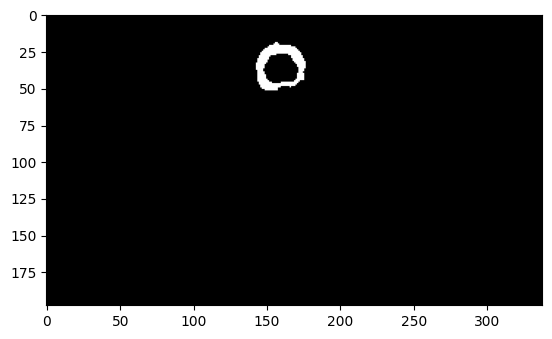

In [56]:
plt.imshow(newC, cmap='gray')

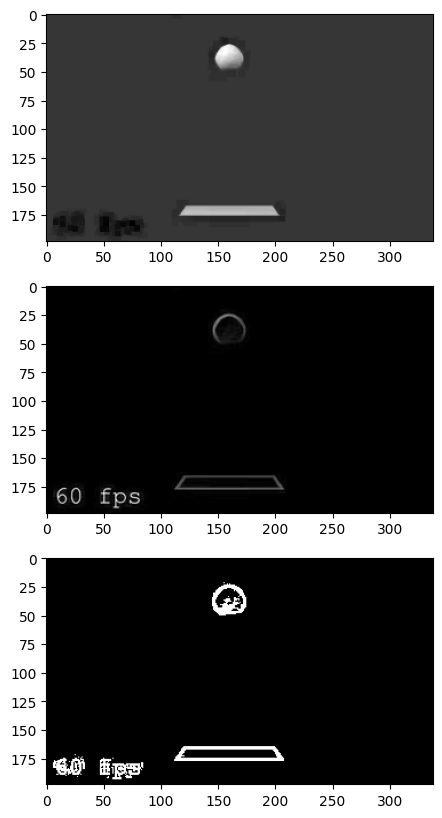

In [57]:
fig, ax = plt.subplots(3, figsize=(10,10))
eroded_frame = cv2.erode(frame, kernel, iterations=1)
differential_image = (frame - eroded_frame)
_, binarized_image = cv2.threshold(differential_image, b, 255, cv2.THRESH_BINARY)
ax[0].imshow(eroded_frame, cmap='gray')
ax[1].imshow(differential_image, cmap='gray')
ax[2].imshow(binarized_image, cmap='gray')

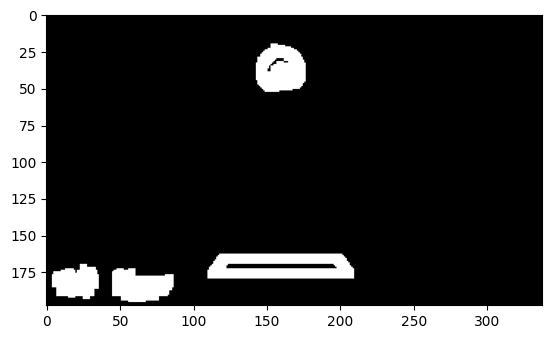

In [58]:
distance_image = binarized_image.copy()

for _ in range(n):
    distance_image = cv2.dilate(distance_image, structuring_element)
plt.imshow(distance_image, cmap='gray')

In [59]:
def get_contour_edge_pixels(contour_image):
    # Find contours in the contour image
    contours, _ = cv2.findContours(contour_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Extract the edge pixels from the contour
    edge_pixels = []
    for contour in contours:
        for point in contour:
            x, y = point[0]
            edge_pixels.append((x, y))

    return np.array(edge_pixels)

(165, 2)


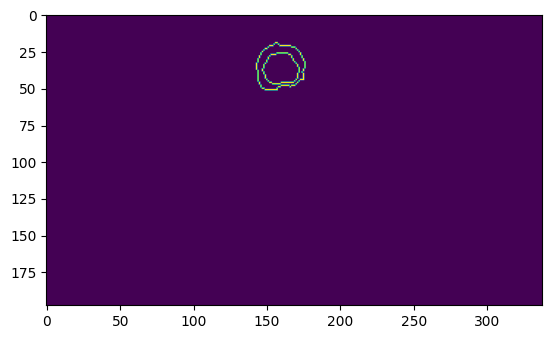

In [60]:
edge_pixels = get_contour_edge_pixels(newC)
print(edge_pixels.shape)

edge_pixels = edge_pixels.reshape(-1, 1, 2)

EP = create_empty_frame(prev_frame.shape[0], prev_frame.shape[1])

cv2.drawContours(EP, edge_pixels, -1, (255, 255, 255), 1)
plt.imshow(EP)

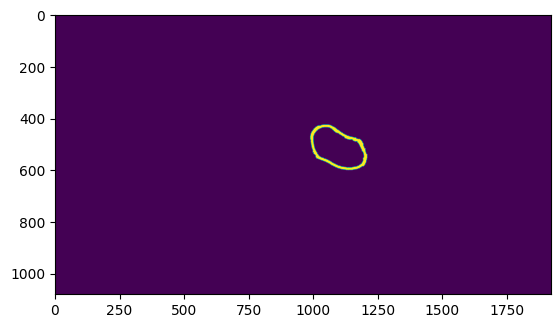

In [15]:
plt.imshow(newC)

In [16]:
def calculate_edge_energy(contour_image, distance_image, x_e):
    neighborhood = np.array([[1, 1, 1],
                            [1, 0, 1],
                            [1, 1, 1]])  # 3x3 neighborhood
    
    S_x_e = np.argwhere(neighborhood == 1) + x_e
    #S_x_e = S_x_e.reshape(-1, 2)
    print(S_x_e.shape)

    N_S_x_e = len(S_x_e)
    print(N_S_x_e)
    total = 0
    for x_ei in S_x_e:
        totalSub = 0
        for neighbor in x_ei:
            totalSub += contour_image[neighbor[1], neighbor[0]].astype(np.int32) - distance_image[neighbor[1], neighbor[0]].astype(np.int32)
        total += totalSub
    #edge_energy = np.sum((contour_image[S_x_e] - distance_image[S_x_e])) / N_S_x_e

    return total




In [22]:
edge = edge_pixels
print(distance_image.shape)

Eedge = calculate_edge_energy(newC, distance_image, edge)
print(Eedge)


eroded_temp = cv2.erode(newC, kernel, iterations=1)
edge_pixels_temp = get_contour_edge_pixels(eroded_temp)
edge_pixels_temp = edge_pixels_temp.reshape(-1, 1, 2)
print("TEMP", edge_pixels_temp.shape)

Eedge_star = calculate_edge_energy(eroded_temp, distance_image, edge_pixels_temp)
print(Eedge_star)

(1080, 1920)
(1113, 8, 2)
1113
909840
TEMP (1113, 1, 2)
(1113, 8, 2)
1113
981495


In [20]:
histBefore = cv2.calcHist([prev_frame], [0], C, [256], [0, 256])
print(prev_frame.shape)
Cedge = get_contour_edge_pixels(C)
Ehist = 0
for e in Cedge:
    for ti in range(-t, t):
        Ehist += histBefore[prev_frame[e[1], e[0]]+ti]
Ehist

(1080, 1920)


array([3043282.], dtype=float32)

In [21]:
histBefore = cv2.calcHist([frame], [0], newC, [256], [0, 256])
print(prev_frame.shape)
Cedge = get_contour_edge_pixels(newC)
Ehist_star = 0
for e in Cedge:
    for ti in range(-t, t):
        Ehist_star += histBefore[prev_frame[e[1], e[0]]+ti]
Ehist_star

(1080, 1920)


array([3230708.], dtype=float32)

In [28]:
print(Ehist_star/Ehist>1)
print(Eedge_star/Eedge< 1+alpha)

[ True]
True
